In [ ]:
# pip install gputil
# pip install torch

In [1]:
import GPUtil
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")          # Assigns CUDA device
    cuda_capability = torch.cuda.get_device_capability(device)
    cuda_cores = torch.cuda.get_device_properties(device).multi_processor_count
    print(f"CUDA Cores Available: {cuda_cores}")
    print(f"CUDA Capability: {cuda_capability}")
else:
    print("CUDA is not available on this system.")

# Get the list of available GPUs
gpus = GPUtil.getGPUs()

if gpus:
    # Iterate through each GPU
    for gpu in gpus:
        print(f"GPU Name: {gpu.name}")
        print(f"GPU ID: {gpu.id}")
        print(f"GPU Memory Total: {gpu.memoryTotal} MB")
        print(f"GPU Memory Free: {gpu.memoryFree} MB")
        print(f"GPU Memory Used: {gpu.memoryUsed} MB")
        print(f"GPU Utilization: {gpu.load*100}%")
        print(f"GPU Temperature: {gpu.temperature} °C")
        print("------------------------")
else:
    print("No GPU found.")


CUDA is not available on this system.
GPU Name: GeForce GTX 760
GPU ID: 0
GPU Memory Total: 4096.0 MB
GPU Memory Free: 3371.0 MB
GPU Memory Used: 725.0 MB
GPU Utilization: nan%
GPU Temperature: 32.0 °C
------------------------


In [49]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [50]:
# Read the text file into a pandas DataFrame
data = pd.read_csv('frek_fonema_v3.0.txt', delim_whitespace=True, header=None)
# Assuming space or tab is the delimiter between columns and no header is present

# Rename columns if needed
data.columns = ['Phoneme', 'Count', 'Frequency']

# FIX THE COMMA-DOT BULLSHIT
# Convert 'Frequency' column to string type
data['Frequency'] = data['Frequency'].astype(str)
# Replace commas with dots in the 'Frequency' column
data['Frequency'] = data['Frequency'].str.replace(',', '.', regex=False)
# Convert the 'Frequency' column to float type
data['Frequency'] = data['Frequency'].astype(float)

# Print or use the imported data as needed
print(data)


   Phoneme    Count  Frequency
0        a  8473320   0.119547
1        o  7134726   0.100661
2        i  7050533   0.099474
3        e  6080196   0.085783
4        n  4218185   0.059513
5        t  3651668   0.051520
6        r  3511665   0.049545
7        s  3255595   0.045932
8        d  2831100   0.039943
9        u  2828080   0.039900
10       v  2702877   0.038134
11       j  2634376   0.037168
12       m  2543126   0.035880
13       k  2461565   0.034729
14       p  2027631   0.028607
15       l  1885640   0.026604
16       z  1281364   0.018078
17       g  1117595   0.015768
18       b   952252   0.013435
19       š   681802   0.009619
20       č   565108   0.007973
21       h   519356   0.007327
22       c   512317   0.007228
23       ć   477359   0.006735
24      nj   430563   0.006075
25       ž   406766   0.005739
26      lj   354311   0.004999
27       đ   163320   0.002304
28       f   122684   0.001731
29      dž     3397   0.000048


In [51]:
# Extracting phonemes, counts, and frequencies from the DataFrame
phonemes = data['Phoneme']      # Extracting 'Phoneme' column
counts = data['Count']          # Extracting 'Count' column
frequencies = data['Frequency'] # Extracting 'Frequency' column
ranks = list(range(1, len(phonemes) + 1))

print(f"{phonemes[1]}\n{counts[1]}\n{frequencies[1]}\n{ranks[1]}")

o
7134726
0.100661
2


In [52]:
# Define the Zipf distribution function
def zipf_distribution(r, A, b):
    return A / np.power(r, b)
    
# Perform curve fitting for Zipf distribution
params_zipf, covariance_zipf = curve_fit(zipf_distribution, ranks, frequencies)

# Extract fitted parameters for Zipf distribution
A_zipf, b_zipf = params_zipf

# Generate the fitted Zipf curve using the fitted parameters
fitted_curve_zipf = zipf_distribution(ranks, A_zipf, b_zipf)

print(f"Fitted Parameters for Zipf Distribution:\n A = {A_zipf}, b = {b_zipf}")

Fitted Parameters for Zipf Distribution:
 A = 0.14411492562613035, b = 0.6338942315248484


In [53]:
# Define Yule's law function
def yules_law(r, A, b, c):
    return A * np.power(r, b) * np.power(c, r)

# Perform curve fitting
popt, pcov = curve_fit(yules_law, ranks, frequencies, maxfev=10000)

# Extract fitted parameters
A_fit, b_fit, c_fit = popt

# Print the fitted parameters
print("Fitted Parameters for Yule's distribution:")
print(f"A = {A_fit}, b = {b_fit}, c = {c_fit}")

# Generate the fitted curve using the fitted parameters
fitted_curve_yule = yules_law(ranks, A_fit, b_fit, c_fit)

Fitted Parameters for Yule's distribution:
A = 0.13370598621029917, b = -0.08793822530185756, c = 0.9024440751323817


In [54]:
# Normalize frequencies to sum up to 1.00
normalized_frequencies = frequencies / np.sum(frequencies)

# Define Sigurd's law function
def sigurd_law(r, a):
    n = 30  # value of n
    return ((1 - a) * np.power(a, (r - 1))) / (1 - np.power(a, n))

# Perform curve fitting for Sigurd's law with adjusted parameters
popt_sigurd, pcov_sigurd = curve_fit(sigurd_law, ranks, normalized_frequencies, p0=[0.5], maxfev=20000)

# Extract fitted parameter for Sigurd's law (k value)
k_fit = popt_sigurd[0]

# Print the fitted parameter for Sigurd's law
print("Fitted Parameter for Sigurd's distribution:")
print(f"a = {k_fit}")

ranks_array = np.array(ranks)
# Generate the fitted curve using the fitted parameter for Sigurd's law
fitted_curve_sigurd = sigurd_law(ranks_array, k_fit)

Fitted Parameter for Sigurd's distribution:
a = 0.8881692586500731


In [55]:
# Define Borodovsky and Gusein-Zade (BGZ) law function
def calculate_fr(r, n):
    return (1 / n) * (np.log(n + 1) - np.log(r))

n = 30  # Assuming n is known

# Assuming 'ranks' contains the rank values for which you want to calculate Fr
fr_values = calculate_fr(ranks, n)
print(fr_values)

[0.11446624 0.09136133 0.07784583 0.06825643 0.06081831 0.05474092
 0.04960257 0.04515152 0.04122542 0.0377134  0.0345364  0.03163602
 0.02896793 0.02649766 0.0241979  0.02204662 0.0200258  0.01812051
 0.01631827 0.0146085  0.01298216 0.01143149 0.00994977 0.00853111
 0.00717038 0.00586302 0.00460501 0.00339276 0.00222305 0.00109299]


In [56]:
# Calculate the mean of the actual data
mean_actual = np.mean(frequencies)

# Calculate total sum of squares (TSS)
tss = np.sum((frequencies - mean_actual) ** 2)

# Calculate residuals for Yule's law and Zipf's law
residuals_yule = frequencies - fitted_curve_yule
residuals_zipf = frequencies - fitted_curve_zipf
residuals_sigurd = frequencies - fitted_curve_sigurd
residuals_bgz = frequencies - fr_values

# Calculate residual sum of squares (RSS)
rss_yule = np.sum(residuals_yule ** 2)
rss_zipf = np.sum(residuals_zipf ** 2)
rss_sigurd = np.sum(residuals_sigurd ** 2)
rss_bgz = np.sum(residuals_bgz ** 2)

# Calculate R^2 for Yule's law and Zipf's law
r_squared_yule = 1 - (rss_yule / tss)
r_squared_zipf = 1 - (rss_zipf / tss)
r_squared_sigurd = 1 - (rss_sigurd / tss)
r_squared_bgz = 1 - (rss_bgz / tss)

print(f"R^2 for Yule's Law: {r_squared_yule}")
print(f"R^2 for Zipf's Law: {r_squared_zipf}")
print(f"R^2 for Sigurd's Law: {r_squared_sigurd}")
print(f"R^2 for BGZ Law: {r_squared_bgz}")


R^2 for Yule's Law: 0.9740038643852638
R^2 for Zipf's Law: 0.8429934766277363
R^2 for Sigurd's Law: 0.9715966300992446
R^2 for BGZ Law: 0.960261174555799


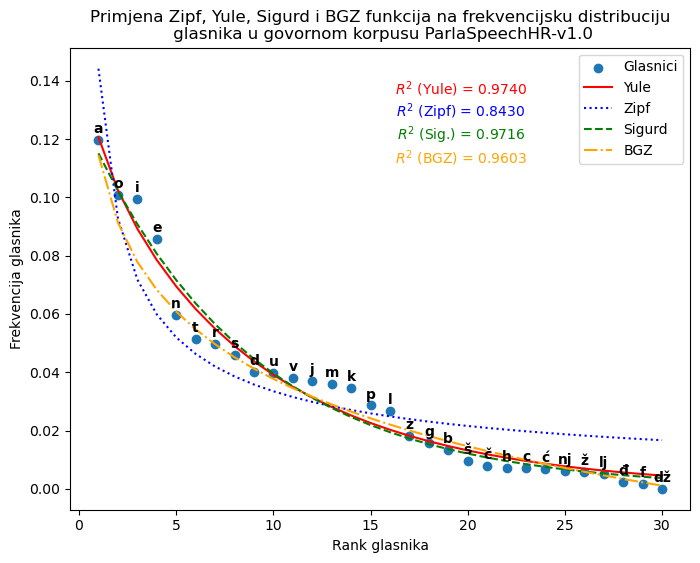

In [63]:
import matplotlib.pyplot as plt

# Plotting both curves and original data
plt.figure(figsize=(8, 6))
plt.scatter(ranks, frequencies, label='Glasnici')
plt.plot(ranks, fitted_curve_yule, color='red', label='Yule', linestyle='-')
plt.plot(ranks, fitted_curve_zipf, color='blue', label='Zipf', linestyle=':')
plt.plot(ranks, fitted_curve_sigurd, color='green', label='Sigurd', linestyle='--')  # Add Sigurd's law line
plt.plot(ranks, fr_values, color='orange', label='BGZ', linestyle='-.')  # Add BGZ law line
plt.xlabel('Rank glasnika')
plt.ylabel('Frekvencija glasnika')
plt.title('Primjena Zipf, Yule, Sigurd i BGZ funkcija na frekvencijsku distribuciju\n glasnika u govornom korpusu ParlaSpeechHR-v1.0')
plt.legend()

# Annotate the plot with R^2 values
# Annotate the plot with R^2 values using LaTeX formatting for superscript 2
plt.text(0.63, 0.91, r"$R^2$ (Yule) = " + f"{r_squared_yule:.4f}", ha='center', va='center', transform=plt.gca().transAxes, color='red', fontsize=10)
plt.text(0.63, 0.86, r"$R^2$ (Zipf) = " + f"{r_squared_zipf:.4f}", ha='center', va='center', transform=plt.gca().transAxes, color='blue', fontsize=10)
plt.text(0.63, 0.81, r"$R^2$ (Sig.) = " + f"{r_squared_sigurd:.4f}", ha='center', va='center', transform=plt.gca().transAxes, color='green', fontsize=10)  # Add R^2 for Sigurd's law
plt.text(0.63, 0.76, r"$R^2$ (BGZ) = " + f"{r_squared_bgz:.4f}", ha='center', va='center', transform=plt.gca().transAxes, color='orange', fontsize=10)  # Add R^2 for BGZ law


# Annotating each point with its corresponding phoneme
for i, txt in enumerate(phonemes):
    plt.annotate(txt, (ranks[i], frequencies[i]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10, fontweight='bold', color='black')

# Saving the plot as a .png file
plt.savefig('yule_zipf_sigurd_bgz_poredba_FONEMA_HR_v3.3.png', dpi=300)  # Specify the filename and dpi (dots per inch)

plt.show()


22.1.2024. Dodajemo Škarić (1991.)

In [42]:
# Specify the file path
skaric_path = "Skaric_frek_fon_1991.txt"

# Read the data into a pandas DataFrame
df_skaric = pd.read_csv(skaric_path, header=None, names=["sk_fon", "sk_freq"])
df_skaric['sk_freq'] = (df_skaric['sk_freq'] / 100).round(4)

# Sort the DataFrame by the second column (sk_freq) in descending order
skaric_sorted = df_skaric.sort_values(by="sk_freq", ascending=False).reset_index(drop=True)

# Extracting phonemes, counts, and frequencies from the DataFrame
sk_fon = skaric_sorted['sk_fon']  # Extracting 'sk_fon' column from the sorted DataFrame
sk_freq = skaric_sorted['sk_freq']  # Extracting 'sk_freq' column from the sorted DataFrame
sk_ranks = list(range(1, len(sk_fon) + 1))

print(f"{sk_fon[1]}\n{sk_freq[1]}\n{sk_ranks[1]}")

# Display the sorted DataFrame
print(skaric_sorted)


i
0.0961
2
   sk_fon  sk_freq
0       a   0.1164
1       i   0.0961
2       e   0.0934
3       o   0.0898
4       n   0.0544
5       s   0.0497
6       r   0.0479
7       u   0.0455
8       t   0.0455
9       j   0.0416
10      m   0.0403
11      d   0.0356
12      v   0.0351
13      k   0.0344
14      l   0.0289
15      z   0.0179
16      g   0.0160
17      p   0.0160
18      b   0.0144
19      š   0.0120
20      c   0.0088
21      č   0.0081
22      ć   0.0075
23      h   0.0071
24     nj   0.0070
25     lj   0.0066
26      ž   0.0063
27      đ   0.0019
28      f   0.0014
29     dž   0.0001


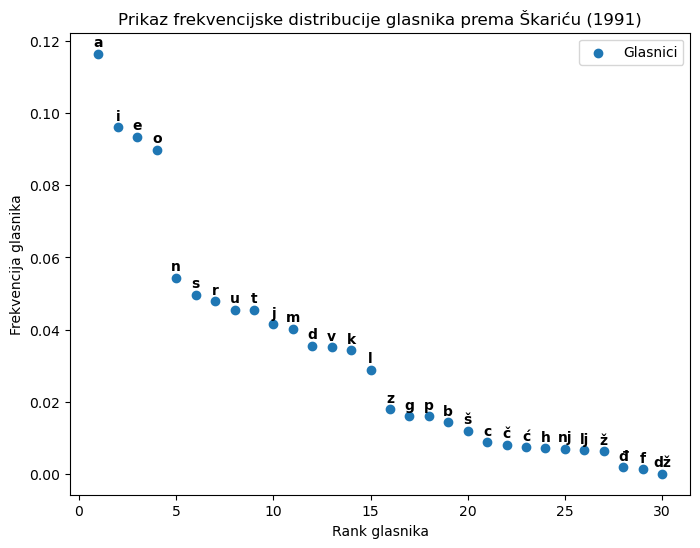

In [64]:
# Plotting both curves and original data
plt.figure(figsize=(8, 6))
plt.scatter(sk_ranks, sk_freq, label='Glasnici')
plt.xlabel('Rank glasnika')
plt.ylabel('Frekvencija glasnika')
plt.title('Prikaz frekvencijske distribucije glasnika prema Škariću (1991)')
plt.legend()

# Annotating each point with its corresponding phoneme
for i, txt in enumerate(sk_fon):
    plt.annotate(txt, (sk_ranks[i], sk_freq[i]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10, fontweight='bold', color='black')

# Saving the plot as a .png file
plt.savefig('škarić_poredba_FONEMA_v1.0.png', dpi=300)  # Specify the filename and dpi (dots per inch)

plt.show()

In [46]:
import numpy as np
from scipy.optimize import curve_fit

# Define the Zipf distribution function
def zipf_distribution_sk(r_sk, A_zipf_sk, b_zipf_sk):
    return A_zipf_sk / np.power(r_sk, b_zipf_sk)
    
# Perform curve fitting for Zipf distribution
params_zipf_sk, covariance_zipf_sk = curve_fit(zipf_distribution_sk, sk_ranks, sk_freq)

# Extract fitted parameters for Zipf distribution
A_zipf_sk, b_zipf_sk = params_zipf_sk

# Generate the fitted Zipf curve using the fitted parameters
fitted_curve_zipf_sk = zipf_distribution_sk(sk_ranks, A_zipf_sk, b_zipf_sk)

print(f"Fitted Parameters for Zipf Distribution:\n A = {A_zipf_sk}, b = {b_zipf_sk}")

# Define Yule's law function
def yules_law_sk(r_sk, A_fit_sk, b_fit_sk, c_fit_sk):
    return A_fit_sk * np.power(r_sk, b_fit_sk) * np.power(c_fit_sk, r_sk)

# Perform curve fitting
popt_yule_sk, pcov_yule_sk = curve_fit(yules_law_sk, sk_ranks, sk_freq, maxfev=10000)

# Extract fitted parameters
A_fit_sk, b_fit_sk, c_fit_sk = popt_yule_sk

# Print the fitted parameters
print("Fitted Parameters for Yule's distribution:")
print(f"A = {A_fit_sk}, b = {b_fit_sk}, c = {c_fit_sk}")

# Generate the fitted curve using the fitted parameters
fitted_curve_yule_sk = yules_law_sk(sk_ranks, A_fit_sk, b_fit_sk, c_fit_sk)

# Normalize sk_freq to sum up to 1.00
normalized_sk_freq = sk_freq / np.sum(sk_freq)

# Define Sigurd's law function
def sigurd_law_sk(r_sk, a_sk):
    n_sk = 30  # value of n_sk
    return ((1 - a_sk) * np.power(a_sk, (r_sk - 1))) / (1 - np.power(a_sk, n_sk))

# Perform curve fitting for Sigurd's law with adjusted parameters
popt_sigurd_sk, pcov_sigurd_sk = curve_fit(sigurd_law_sk, sk_ranks, normalized_sk_freq, p0=[0.5], maxfev=20000)

# Extract fitted parameter for Sigurd's law (k value)
k_fit_sk = popt_sigurd_sk[0]

# Print the fitted parameter for Sigurd's law
print("Fitted Parameter for Sigurd's distribution:")
print(f"a = {k_fit_sk}")

ranks_array_sk = np.array(sk_ranks)
# Generate the fitted curve using the fitted parameter for Sigurd's law
fitted_curve_sigurd_sk = sigurd_law_sk(ranks_array_sk, k_fit_sk)

# Define Borodovsky and Gusein-Zade (BGZ) law function
def calculate_fr_sk(r_sk, n_sk):
    return (1 / n_sk) * (np.log(n_sk + 1) - np.log(r_sk))

n_sk = 30  # Assuming n_sk is known

# Assuming 'sk_ranks' contains the rank values for which you want to calculate Fr
fr_values_sk = calculate_fr_sk(sk_ranks, n_sk)
print(fr_values_sk)

# Calculate the mean of the actual data
mean_actual_sk = np.mean(sk_freq)

# Calculate total sum of squares (TSS)
tss_sk = np.sum((sk_freq - mean_actual_sk) ** 2)

# Calculate residuals for Yule's law and Zipf's law
residuals_yule_sk = sk_freq - fitted_curve_yule_sk
residuals_zipf_sk = sk_freq - fitted_curve_zipf_sk
residuals_sigurd_sk = sk_freq - fitted_curve_sigurd_sk
residuals_bgz_sk = sk_freq - fr_values_sk

# Calculate residual sum of squares (RSS)
rss_yule_sk = np.sum(residuals_yule_sk ** 2)
rss_zipf_sk = np.sum(residuals_zipf_sk ** 2)
rss_sigurd_sk = np.sum(residuals_sigurd_sk ** 2)
rss_bgz_sk = np.sum(residuals_bgz_sk ** 2)

# Calculate R^2 for Yule's law and Zipf's law
r_squared_yule_sk = 1 - (rss_yule_sk / tss_sk)
r_squared_zipf_sk = 1 - (rss_zipf_sk / tss_sk)
r_squared_sigurd_sk = 1 - (rss_sigurd_sk / tss_sk)
r_squared_bgz_sk = 1 - (rss_bgz_sk / tss_sk)

print(f"R^2 for Yule's Law: {r_squared_yule_sk}")
print(f"R^2 for Zipf's Law: {r_squared_zipf_sk}")
print(f"R^2 for Sigurd's Law: {r_squared_sigurd_sk}")
print(f"R^2 for BGZ Law: {r_squared_bgz_sk}")


Fitted Parameters for Zipf Distribution:
 A = 0.13950015737677623, b = 0.6256231847152111
Fitted Parameters for Yule's distribution:
A = 0.1286528675446394, b = -0.08211614863050211, c = 0.90398238670559
Fitted Parameter for Sigurd's distribution:
a = 0.8907580900006783
[0.11446624 0.09136133 0.07784583 0.06825643 0.06081831 0.05474092
 0.04960257 0.04515152 0.04122542 0.0377134  0.0345364  0.03163602
 0.02896793 0.02649766 0.0241979  0.02204662 0.0200258  0.01812051
 0.01631827 0.0146085  0.01298216 0.01143149 0.00994977 0.00853111
 0.00717038 0.00586302 0.00460501 0.00339276 0.00222305 0.00109299]
R^2 for Yule's Law: 0.9682656510185376
R^2 for Zipf's Law: 0.8364265341268702
R^2 for Sigurd's Law: 0.9657630188940998
R^2 for BGZ Law: 0.9614397839693515


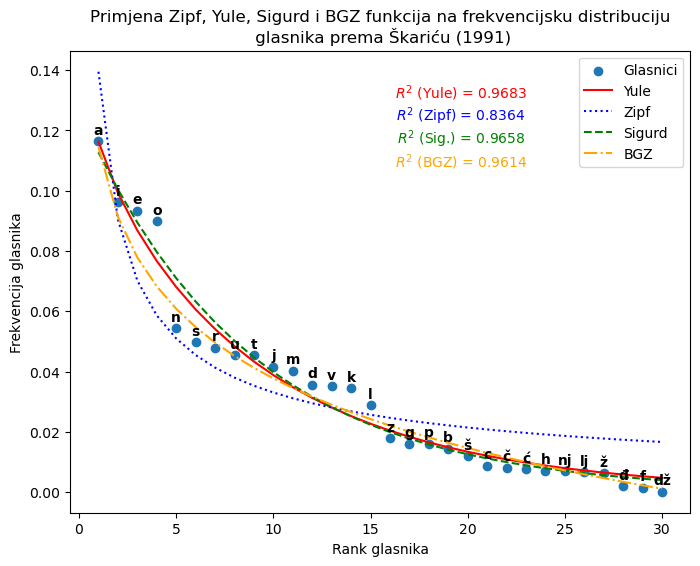

In [59]:
import matplotlib.pyplot as plt

# Plotting both curves and original data
plt.figure(figsize=(8, 6))
plt.scatter(sk_ranks, sk_freq, label='Glasnici')
plt.plot(sk_ranks, fitted_curve_yule_sk, color='red', label='Yule', linestyle='-')
plt.plot(sk_ranks, fitted_curve_zipf_sk, color='blue', label='Zipf', linestyle=':')
plt.plot(sk_ranks, fitted_curve_sigurd_sk, color='green', label='Sigurd', linestyle='--')  # Add Sigurd's law line
plt.plot(sk_ranks, fr_values_sk, color='orange', label='BGZ', linestyle='-.')  # Add BGZ law line
plt.xlabel('Rank glasnika')
plt.ylabel('Frekvencija glasnika')
plt.title('Primjena Zipf, Yule, Sigurd i BGZ funkcija na frekvencijsku distribuciju\n glasnika prema Škariću (1991)')
plt.legend()

# Annotate the plot with R^2 values
# Annotate the plot with R^2 values using LaTeX formatting for superscript 2
plt.text(0.63, 0.91, r"$R^2$ (Yule) = " + f"{r_squared_yule_sk:.4f}", ha='center', va='center', transform=plt.gca().transAxes, color='red', fontsize=10)
plt.text(0.63, 0.86, r"$R^2$ (Zipf) = " + f"{r_squared_zipf_sk:.4f}", ha='center', va='center', transform=plt.gca().transAxes, color='blue', fontsize=10)
plt.text(0.63, 0.81, r"$R^2$ (Sig.) = " + f"{r_squared_sigurd_sk:.4f}", ha='center', va='center', transform=plt.gca().transAxes, color='green', fontsize=10)  # Add R^2 for Sigurd's law
plt.text(0.63, 0.76, r"$R^2$ (BGZ) = " + f"{r_squared_bgz_sk:.4f}", ha='center', va='center', transform=plt.gca().transAxes, color='orange', fontsize=10)  # Add R^2 for BGZ law

# Annotating each point with its corresponding phoneme
for i, txt in enumerate(sk_fon):
    plt.annotate(txt, (sk_ranks[i], sk_freq[i]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10, fontweight='bold', color='black')

# Saving the plot as a .png file
plt.savefig('škarić_poredba_FONEMA_funkcije_v1.1.png', dpi=300)  # Specify the filename and dpi (dots per inch)

plt.show()


# SPACER

# SPACER

# SPACER

## Priprema ParlaSpeechHR .json filea za obradu:

* DIPL.FON: frekvencija glasnika
* JKIM: spomen mladih, studenata, djece
* STAT: seminar neš idk

In [ ]:
#pip install jsonlines

In [1]:
import pandas as pd
import pickle
import jsonlines
import unicodedata

In [2]:
# Mapping dictionary for specific character replacements
unicode_mapping = {
    '\u0161': 'š',  # š
    '\u017e': 'ž',  # ž
    '\u010d': 'č',  # č
    '\u0111': 'đ',  # đ
    '\u0107': 'ć'   # ć
}

# Function to normalize words using the mapping dictionary
def normalize_words(words_list):
    normalized_words = []
    for word in words_list:
        normalized_word = ''.join(unicode_mapping.get(char, char) for char in word)
        normalized_words.append(normalized_word)
    return normalized_words

In [3]:
# Read the JSON Lines file

import jsonlines
import pandas as pd
import codecs

# Function to replace specific Unicode characters in words_list
def replace_unicode_chars(words_list):
    replacements = {
        '\u0161': 'š',  # š
        '\u017e': 'ž',  # ž
        '\u010d': 'č',  # č
        '\u0111': 'đ',  # đ
        '\u0107': 'ć'   # ć
    }
    return ["".join(replacements.get(char, char) for char in word) for word in words_list]
    
print("Loading JSONL file")
# Read the JSON Lines file and process the data
data = []
with codecs.open('ParlaSpeech-HR.v1.0.jsonl', 'r', encoding='utf-8') as file:
    reader = jsonlines.Reader(file)
    for line in reader:
        line['words'] = replace_unicode_chars(line['words'])
        data.append(line)

print("Sorting by orig_file, utterance_id_start and start...")
# Sort the data by a specific field (e.g., 'utterance_id_start')
sorted_data = sorted(data, key=lambda x: (x.get('orig_file'), x.get('utterance_id_start'), x.get('start')))

# Convert the sorted data to a DataFrame (optional but useful)
df = pd.DataFrame(sorted_data)


columns_to_drop = ['word_start_times',
                   'utterance_id_end',
                   'norm_words_start_times',
                   'norm_words',
                   'end',
                   'split',
                   'norm_words_edited',
                  # 'path',
                  # 'utterance_id_start'
                  ]
print(f"Dropping columns: {columns_to_drop}")

# Drop specified columns from the DataFrame
df.drop(columns=columns_to_drop, inplace=True)


# Save as CSV
df.to_csv('sorted_ParlaSpeech-HR.v1.1.csv', index=False)
print("Saved as .CSV!")

Loading JSONL file
Sorting by orig_file, utterance_id_start and start...
Dropping columns: ['word_start_times', 'utterance_id_end', 'norm_words_start_times', 'norm_words', 'end', 'split', 'norm_words_edited']
Saved as .CSV!


In [4]:
df_copy = df.copy()

# Join the lists of words into a single sentence in a new column 'sentence'
df_copy['sentence'] = df_copy['words'].apply(lambda x: ' '.join(x)).str.lower()

# Drop the original 'words' column if not needed anymore
df_copy.drop(columns='words', inplace=True)

print(df_copy['sentence'])

0         konačni prijedlog zakona o izmjenama i dopunam...
1         u svezi sa člankom 190. poslovnika hrvatskog s...
2         za zakonodavstvo i odbor za financije i državn...
3         hvala lijepo gospodine potpredsjedniče hrvatsk...
4         zakona o izmjenama i dopunama zakona o doprino...
                                ...                        
403920    hrvatski narod direktno odlučuje, a kad se rad...
403921    naše domovine andrej plenković koji je neuspje...
403922                  zanima me hoće li andrej plenković,
403923    znači po pitanju novog zakona o referendumima ...
403924    pa ćemo mi se često ugledati na zemlje zapadne...
Name: sentence, Length: 403925, dtype: object


In [5]:
# Group by 'orig_file' and aggregate 'sentence' into a single text chunk
df_combined = df_copy.groupby('path')['sentence'].apply(' '.join).reset_index()
print(df_combined['sentence'])

0         lijepo. kolegice i kolege, nemojte se vi varda...
1         hdz želi pokušati dati obećanje za 6 mjeseci d...
2         ste imali rast 3%, a sada predlaže kao fol, g....
3         ma dajte molim vas, to nitko ne vjeruje, to ne...
4         djeca mogu stjecati znanje i obrazovati se. da...
                                ...                        
403920    prosječna plaća u hrvatskoj, svijež podatak ne...
403921    krenuti ću na onom dijelu gdje se opisuju poje...
403922    poznavanje niza propisa da bi uopće mogao polo...
403923    pa konkretno i nekih drugih stvari, drugih zak...
403924    tako da prije svega, moramo, htio bi na taj na...
Name: sentence, Length: 403925, dtype: object


In [38]:
# Save as CSV
df_combined.to_csv('blokovi_tekstova_ParlaSpeech-HR.v1.2.csv', index=False)
print("Saved as .CSV!")

Saved as .CSV!


# PARSIRANJE NJ LJ DŽ

In [40]:
# from collections import Counter

# # Concatenate all sentences into a single string
# all_text = ' '.join(df_combined['sentence'])

# # Count the frequency of each character
# character_frequency = Counter(all_text.lower())  # Convert to lowercase for uniform counting

# # Display the character frequencies
# print(character_frequency)


Counter({' ': 14419033, 'a': 8473320, 'o': 7134726, 'i': 7050533, 'e': 6080196, 'n': 4648748, 't': 3651668, 'r': 3511665, 'j': 3419250, 's': 3255595, 'd': 2834497, 'u': 2828080, 'v': 2702877, 'm': 2543126, 'k': 2461565, 'l': 2239951, 'p': 2027631, 'z': 1281364, 'g': 1117595, ',': 966159, 'b': 952252, 'š': 681802, '.': 633399, 'č': 565108, 'h': 519356, 'c': 512317, 'ć': 477359, 'ž': 410163, 'đ': 163320, 'f': 122684, '0': 121397, '1': 73991, '2': 69318, '-': 60284, '5': 36839, '?': 34026, '3': 32637, '4': 23869, '6': 21275, '7': 20024, '8': 18816, '%': 18226, '9': 17383, "'": 4564, '_': 3838, '„': 3129, '“': 3083, 'x': 2429, '/': 1820, ':': 1656, 'w': 1581, 'y': 1202, '!': 416, ')': 352, '(': 258, '+': 238, 'q': 134, ';': 77, '"': 41, 'ü': 39, '¾': 35, '&': 26, '–': 22, '¼': 22, '>': 10, '—': 10, '@': 10, '’': 8, 'ö': 7, '̊': 6, '=': 4, '#': 4, '¸': 3, 'ӧ': 3, '‰': 3, '*': 2, '€': 2, 'ä': 2, '°': 1, '½': 1, '´': 1, '′': 1, 'ô': 1, 'ţ': 1, 'π': 1})


In [6]:
from collections import Counter

# Concatenate all sentences into a single string
all_text = ' '.join(df_combined['sentence'])

# Convert all the text to lowercase
all_text_lower = all_text.lower()

# Define special character sequences to be removed
special_sequences = ["nj", "lj", "dž"]

# Initialize counters for special sequences
special_sequence_counts = {seq: 0 for seq in special_sequences}

# Count occurrences of special sequences and remove them from the text
for seq in special_sequences:
    count = all_text_lower.count(seq)
    special_sequence_counts[seq] = count
    all_text_lower = all_text_lower.replace(seq, '')

# Count the frequency of each character
character_frequency = Counter(all_text_lower)

# Display the character frequencies and counts of special sequences
print("Character frequencies:")
print(character_frequency)
print("\nCounts of special sequences:")
print(special_sequence_counts)


Character frequencies:
Counter({' ': 14419033, 'a': 8473320, 'o': 7134726, 'i': 7050533, 'e': 6080196, 'n': 4218185, 't': 3651668, 'r': 3511665, 's': 3255595, 'd': 2831100, 'u': 2828080, 'v': 2702877, 'j': 2634376, 'm': 2543126, 'k': 2461565, 'p': 2027631, 'l': 1885640, 'z': 1281364, 'g': 1117595, ',': 966159, 'b': 952252, 'š': 681802, '.': 633399, 'č': 565108, 'h': 519356, 'c': 512317, 'ć': 477359, 'ž': 406766, 'đ': 163320, 'f': 122684, '0': 121397, '1': 73991, '2': 69318, '-': 60284, '5': 36839, '?': 34026, '3': 32637, '4': 23869, '6': 21275, '7': 20024, '8': 18816, '%': 18226, '9': 17383, "'": 4564, '_': 3838, '„': 3129, '“': 3083, 'x': 2429, '/': 1820, ':': 1656, 'w': 1581, 'y': 1202, '!': 416, ')': 352, '(': 258, '+': 238, 'q': 134, ';': 77, '"': 41, 'ü': 39, '¾': 35, '&': 26, '–': 22, '¼': 22, '>': 10, '—': 10, '@': 10, '’': 8, 'ö': 7, '̊': 6, '=': 4, '#': 4, '¸': 3, 'ӧ': 3, '‰': 3, '*': 2, '€': 2, 'ä': 2, '°': 1, '½': 1, '´': 1, '′': 1, 'ô': 1, 'ţ': 1, 'π': 1})

Counts of specia

In [7]:
#abcčćdđefghijklmnoprsštuvzž
# Your list of characters
characters = list('abcčćdđefghijklmnoprsštuvzž')

# Add 'nj', 'lj', and 'dž' to the list of characters
special_sequences = ['nj', 'lj', 'dž']
characters += special_sequences

# Create a dictionary to hold character frequencies
char_freq_dict = {char: character_frequency[char] for char in characters}

# Include counts of special sequences in char_freq_dict
char_freq_dict.update(special_sequence_counts)

# Sort char_freq_dict by frequency in descending order
char_freq_dict = dict(sorted(char_freq_dict.items(), key=lambda x: x[1], reverse=True))

# Display the character frequencies
print(char_freq_dict)


{'a': 8473320, 'o': 7134726, 'i': 7050533, 'e': 6080196, 'n': 4218185, 't': 3651668, 'r': 3511665, 's': 3255595, 'd': 2831100, 'u': 2828080, 'v': 2702877, 'j': 2634376, 'm': 2543126, 'k': 2461565, 'p': 2027631, 'l': 1885640, 'z': 1281364, 'g': 1117595, 'b': 952252, 'š': 681802, 'č': 565108, 'h': 519356, 'c': 512317, 'ć': 477359, 'nj': 430563, 'ž': 406766, 'lj': 354311, 'đ': 163320, 'f': 122684, 'dž': 3397}


In [8]:
# Calculate the total sum of frequencies
total_sum = sum(char_freq_dict.values())

# Merge counts and percentages into the same dictionary
combined_dict = {char: {'count': freq, 'freq%': round((freq / total_sum) * 100, 3)} for char, freq in char_freq_dict.items()}

# Display the combined dictionary
print(combined_dict)


{'a': {'count': 8473320, 'freq%': 11.955}, 'o': {'count': 7134726, 'freq%': 10.066}, 'i': {'count': 7050533, 'freq%': 9.947}, 'e': {'count': 6080196, 'freq%': 8.578}, 'n': {'count': 4218185, 'freq%': 5.951}, 't': {'count': 3651668, 'freq%': 5.152}, 'r': {'count': 3511665, 'freq%': 4.954}, 's': {'count': 3255595, 'freq%': 4.593}, 'd': {'count': 2831100, 'freq%': 3.994}, 'u': {'count': 2828080, 'freq%': 3.99}, 'v': {'count': 2702877, 'freq%': 3.813}, 'j': {'count': 2634376, 'freq%': 3.717}, 'm': {'count': 2543126, 'freq%': 3.588}, 'k': {'count': 2461565, 'freq%': 3.473}, 'p': {'count': 2027631, 'freq%': 2.861}, 'l': {'count': 1885640, 'freq%': 2.66}, 'z': {'count': 1281364, 'freq%': 1.808}, 'g': {'count': 1117595, 'freq%': 1.577}, 'b': {'count': 952252, 'freq%': 1.343}, 'š': {'count': 681802, 'freq%': 0.962}, 'č': {'count': 565108, 'freq%': 0.797}, 'h': {'count': 519356, 'freq%': 0.733}, 'c': {'count': 512317, 'freq%': 0.723}, 'ć': {'count': 477359, 'freq%': 0.673}, 'nj': {'count': 43056

In [15]:
import csv

# File path to save the CSV
file_path = 'Frekvencija_glasnika_ParlaSpeechHR_v2.0.csv'

# Writing the sorted dictionary to a CSV file with UTF-8 encoding
with open(file_path, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['Character', 'Count', 'Freq%']  # Updated field names
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    # Write the header
    writer.writeheader()

    # Write the data rows
    for char, data in sorted_combined.items():
        writer.writerow({'Character': char, 'Count': data['count'], 'Freq%': data['freq%']})

print(f"CSV file '{file_path}' has been saved.")


CSV file 'Frekvencija_glasnika_ParlaSpeechHR_v2.0.csv' has been saved.


In [63]:
import jsonlines

# Path to your JSONL file
jsonl_file_path = 'ParlaSpeech-HR.v1.0.jsonl'

total_word_count = 0

# Read the JSONL file and count words in each line
with jsonlines.open(jsonl_file_path, 'r') as file:
    for line in file:
        if 'words' in line:  # Check if 'words' field exists
            words_list = line['words']  # Assuming 'words' is a list field in each JSON object
            total_word_count += len(words_list)

print(f"Total number of words in the JSONL file: {total_word_count}")


Total number of words in the JSONL file: 14419034


# Frekvencije glasnika u ParlaSpeechHR-v1.0 (v1.0)

Character,Count,Freq%
a,8473320,11.823
o,7134726,9.955
i,7050533,9.838
e,6080196,8.484
n,4648748,6.487
t,3651668,5.095
r,3511665,4.9
j,3419250,4.771
s,3255595,4.543
d,2834497,3.955
u,2828080,3.946
v,2702877,3.771
m,2543126,3.549
k,2461565,3.435
l,2239951,3.126
p,2027631,2.829
z,1281364,1.788
g,1117595,1.559
b,952252,1.329
š,681802,0.951
č,565108,0.789
h,519356,0.725
c,512317,0.715
ć,477359,0.666
ž,410163,0.572
đ,163320,0.228
f,122684,0.171